In [51]:
import numpy as np
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def gen_pc_data(N, M, R, percent_moonlight):
    
    # First generate W
    W = np.zeros((N,R))
    moonlight_genes = np.random.uniform(0,1,N)
    moonlight_genes = moonlight_genes<percent_moonlight
    
    # Pick the modules for each gene
    for gene_idx in range(N):
        if moonlight_genes[gene_idx]:
            num_mods = np.random.randint(2,R+1)
            gene_mods = np.random.randint(0,R,num_mods)
            W[gene_idx, gene_mods] = 1
        else: 
            gene_mod = np.random.randint(0,R)
            W[gene_idx, gene_mod] = 1
    # Pick the relative expression levels of each gene for each module
    for mod_idx in range(R):
        # Handel the case where a module has no genes (very unlikely for N >> R)
        if W[:,mod_idx].sum() == 0:
            W[np.random.randint(0,N),mod_idx] = 1
            
        else:
            col_arr = W[:,mod_idx]
            col_sum = int(col_arr.sum())
            dir_params = np.ones(col_sum)
            gene_expressions_arr = np.random.dirichlet(dir_params)
            idx_arr = np.argwhere(col_arr != 0)
            col_arr[idx_arr] = gene_expressions_arr[:,np.newaxis]
            W[:, mod_idx] = col_arr
            
    # Then generate H
    H = np.ones((R,M))
    H = np.apply_along_axis(np.random.dirichlet, 0, H)
    
    # Now generate V from W and H
    #TODO change the way we add counts, should be based on the number of samples (does it need to be different 
    # acrross samples as well?)
    V = 1e6*np.matmul(W, H)
    V = np.random.poisson(V)
            
    return W, H, V

In [3]:
# Generate simulated data where we are observing 100 genes in 60 samples with 5 gene batteries and ~5 percent
# of genes are moonlighting genes
W1_true, H1_true, V1 = gen_pc_data(20,10,3,0.05)
W2_true, H2_true, V2 = gen_pc_data(20,10,4,0.05)
W3_true, H3_true, V3 = gen_pc_data(20,10,5,0.05)

In [4]:
def iterate_NMF(V, R, N):
    
    iteration_num_list = []
    dims = V.shape
    C = V.sum(axis=0)
    C = C[np.newaxis,:]
    
    best_LL = -1
    best_W = -1
    best_H = -1
    
    for epoch in range(N):
        
        # Initiate random W and H
        epoch_W, epoch_H = np.ones((dims[0],R)), np.ones((R,dims[1]))
        epoch_W = np.apply_along_axis(np.random.dirichlet, 0, epoch_W)
        epoch_H = np.apply_along_axis(np.random.dirichlet, 0, epoch_H)
        epoch_LL = -1

        for iteration in range(100000):

            # Get matrices for W and H update
            Lamda = np.multiply(C,np.matmul(epoch_W,epoch_H))
            P = np.divide(V, Lamda)
            CH = np.multiply(C,epoch_H)

            # Broadcast into higher dimensions and perform element-wise multiplication for W update
            P_3d = P[:,np.newaxis,:]
            CH_3d = CH[np.newaxis,:,:]
            L_W = np.multiply(P_3d,CH_3d).sum(axis=2)

            # Get new W
            W_new = np.multiply(epoch_W,L_W)
            norm_term = W_new.sum(axis=0)[np.newaxis,:]
            W_new = np.divide(W_new,norm_term)

            # Broadcast into higher dimensions and perform element-wise multiplication for H update
            W_3d = epoch_W[:,:,np.newaxis]
            L_H = np.multiply(P_3d,W_3d).sum(axis=0)

            # Get new H
            H_new = np.multiply(epoch_H,L_H)

            # Update W and H
            epoch_W = W_new
            epoch_H = H_new
            
            # Calculate the negative log likelyhood and end iteration if it has not changed significantly
            if iteration%100 == 0:
                iteration_LL = np.sum(np.subtract(np.multiply(V, np.log(Lamda)), Lamda))
                
                if epoch_LL == -1:
                    epoch_LL = iteration_LL
                    
                elif np.abs(np.subtract(iteration_LL, epoch_LL)) < 0.01:
                    epoch_LL = iteration_LL
                    iteration_num_list.append(iteration)
                    break
                
                else: epoch_LL = iteration_LL
         
        # Update the best parameters if the log-likelyhood is better
        if epoch_LL > best_LL or best_LL == -1:
            best_LL = epoch_LL
            best_W = epoch_W
            best_H = epoch_H

    return best_W, best_H, best_LL, iteration_num_list

def find_best_fit_r(V, R_range_vec, N):
    W_list = []
    H_list = []
    LL_list = []
    
    for R in range(R_range_vec[0],R_range_vec[1]+1):
        results = iterate_NMF(V, R, N)
        W_list.append(results[0])
        H_list.append(results[1])
        LL_list.append(results[2])
        
    return W_list, H_list, LL_list
    

In [16]:
test_1 = find_best_fit_r(V1, (3,6), 5)
test_2 = find_best_fit_r(V2, (3,6), 5)
test_3 = find_best_fit_r(V3, (3,6), 5)

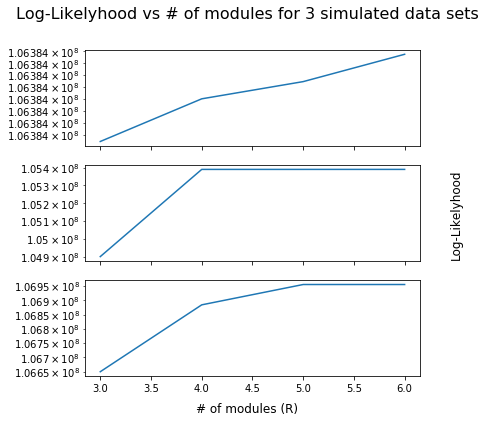

In [15]:
r_list = [3,4,5,6]
fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)
axs[0].semilogy(r_list, test_1[2])
axs[1].semilogy(r_list, test_2[2])
axs[2].semilogy(r_list, test_3[2])
fig.text(0.5, 0.04, "# of modules (R)", ha="center", fontsize=12)
fig.text(1, 0.5, "Log-Likelyhood", va="center", ha="right", rotation="vertical", fontsize=12)
fig.suptitle("Log-Likelyhood vs # of modules for 3 simulated data sets", fontsize=16)
plt.show()

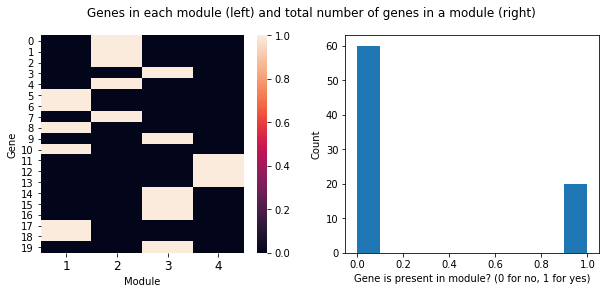

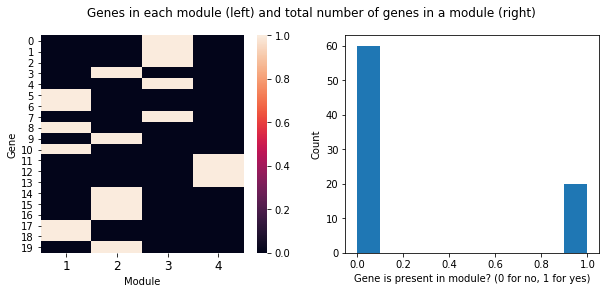

In [94]:
#TODO find a smarter way of creating the cutoff (variance or mean based maybe?)
W_hat = test_2[0][1]
row_norm_numer = W_hat.sum(axis=1)
W_hat = np.divide(W_hat, row_norm_numer[:,np.newaxis])

row_norm_numer = W2_true.sum(axis=1)
W2_true_norm = np.divide(W2_true, row_norm_numer[:,np.newaxis])

fig1, ax1 = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(W_hat>0.2, ax=ax1[0])
ax1[1].hist((W_hat.flatten()>0.2).astype(int))
ax1[0].set_xlabel("Module")
ax1[0].set_xticklabels([1,2,3,4], fontsize=12)
ax1[0].set_ylabel("Gene")
ax1[1].set_xlabel("Gene is present in module? (0 for no, 1 for yes)")
ax1[1].set_ylabel("Count")
fig1.suptitle("Genes in each module (left) and total number of genes in a module (right)")

fig2, ax2 = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(W2_true_norm>0, ax=ax2[0])
ax2[1].hist(W2_true_norm.flatten())
ax2[0].set_xlabel("Module")
ax2[0].set_xticklabels([1,2,3,4], fontsize=12)
ax2[0].set_ylabel("Gene")
ax2[1].set_xlabel("Gene is present in module? (0 for no, 1 for yes)")
ax2[1].set_ylabel("Count")
fig2.suptitle("Genes in each module (left) and total number of genes in a module (right)")

plt.show()

In [57]:
adler_data = pd.read_csv("w09-data.tbl", header=None, index_col=0, delim_whitespace=True)
adler_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,1375,1491,410,246,1479,313,151,650,36,2339,...,914,336,69,40,455,6,787,311,1658,1092
apricot,10,220,26,120,76,444,310,0,75,234,...,414,50,140,359,466,160,108,452,147,96
artichoke,1750,2590,726,4144,2474,627,1433,171,2340,45,...,98,1336,3785,1188,516,2161,698,1815,2540,2634
arugula,926,1392,388,2248,1376,336,737,92,1273,29,...,65,676,2176,614,274,1228,376,1009,1363,1458
asparagus,551,584,133,119,600,125,68,256,12,946,...,386,136,33,16,182,6,332,149,659,430
avocado,627,912,207,1470,914,218,538,55,822,26,...,33,495,1461,399,194,818,218,646,943,902
banana,318,357,76,76,354,82,36,137,13,544,...,261,102,16,5,126,0,219,79,374,248
basil,2465,2501,640,496,2648,530,283,1173,81,4256,...,1771,612,160,61,873,12,1491,606,2914,1965
beet,516,534,126,105,582,111,57,249,18,864,...,388,138,22,12,183,7,322,127,615,397


In [31]:
adler_data_results = find_best_fit_r(adler_data.values, (3,6), 5)

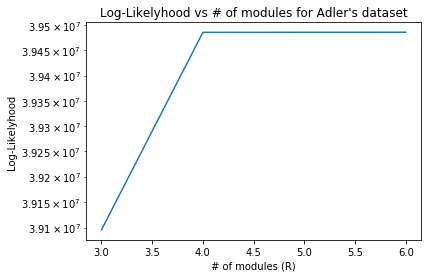

In [32]:
plt.semilogy(r_list, adler_data_results[2])
plt.xlabel("# of modules (R)")
plt.ylabel("Log-Likelyhood")
plt.title("Log-Likelyhood vs # of modules for Adler's dataset")
plt.show()

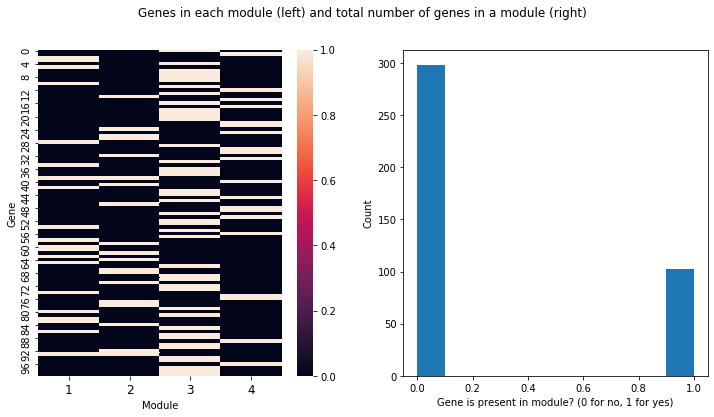

In [93]:
adler_W = adler_data_results[0][1]
row_norm_numer = adler_W.sum(axis=1)
adler_W = np.divide(adler_W, row_norm_numer[:,np.newaxis])

fig1, ax1 = plt.subplots(1, 2, figsize=(12,6))
sns.heatmap(adler_W>0.2, ax=ax1[0])
ax1[1].hist((adler_W.flatten()>0.2).astype(int))
ax1[0].set_xlabel("Module")
ax1[0].set_xticklabels([1,2,3,4], fontsize=12)
ax1[0].set_ylabel("Gene")
ax1[1].set_xlabel("Gene is present in module? (0 for no, 1 for yes)")
ax1[1].set_ylabel("Count")
fig1.suptitle("Genes in each module (left) and total number of genes in a module (right)")
plt.show()

In [73]:
adler_W_bool = adler_W>0.1
gene_names_list = list(adler_data.index.values)


module_list = []

for col in range(len(adler_W_bool[0,:])):
    module_size = adler_W_bool[:,col].sum()
    module_genes = list(compress(gene_names_list,adler_W_bool[:,col]))
    print("Module "+str(col+1)+" has "+str(module_size)+" genes, the genes are:")
    print(module_genes)
    print()

adler_moonlight_bool = adler_W_bool.sum(axis=1)>1
adler_moonlight_gene_num = adler_moonlight_bool.sum()
adler_moonlight_gene_names = list(compress(gene_names_list,adler_moonlight_bool))    
print("There are " + str(adler_moonlight_gene_num) + " moonlight genes, the genes are:")
print(adler_moonlight_gene_names)

Module 1 has 20 genes, the genes are:
['artichoke', 'arugula', 'avocado', 'blueberry', 'cranberry', 'fig', 'grape', 'honeydew', 'mango', 'mustard', 'okra', 'olive', 'orange', 'papaya', 'plantain', 'radish', 'raspberry', 'rhubarb', 'sage', 'tomato']

Module 2 has 20 genes, the genes are:
['cantaloupe', 'cilantro', 'coconut', 'coriander', 'cranberry', 'elderberry', 'grape', 'guava', 'kohlrabi', 'nectarine', 'onion', 'oregano', 'parsnip', 'pea', 'pepper', 'potato', 'pumpkin', 'rosemary', 'thyme', 'tomato']

Module 3 has 43 genes, the genes are:
['anise', 'asparagus', 'banana', 'basil', 'beet', 'blackberry', 'broccoli', 'cabbage', 'carrot', 'cayenne', 'celery', 'chard', 'cherry', 'cucumber', 'fennel', 'garlic', 'ginger', 'gooseberry', 'horseradish', 'huckleberry', 'kiwi', 'lentil', 'lime', 'maize', 'melon', 'mushroom', 'parsley', 'peach', 'pear', 'persimmon', 'pineapple', 'quince', 'raisin', 'rutabaga', 'scallion', 'spinach', 'tamarind', 'tangerine', 'turnip', 'wasabi', 'watermelon', 'yam'